In [1]:
import pandas as pd
import numpy as np
import scipy
import random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = '../data/AdSmartABdata.csv'
ad_df = pd.read_csv(file_name)

## Sequential Testing

In [3]:
clean_ad_df = ad_df[(ad_df['yes'] == 1) ^ (ad_df['no'] == 1)]
clean_ad_df['converted'] = clean_ad_df.yes
clean_control = clean_ad_df.groupby('experiment').get_group('control')
clean_exposed = clean_ad_df.groupby('experiment').get_group('exposed')
# clean_ad_df

In [4]:
class SequentialTest:
    def __init__(self,exposed,control,sample_size):
        self.exposed = exposed
        self.control = control
        self.sample_size = sample_size
        
        '''
        initialise startup variables
        '''

    def stoppingRule(self, T, C):
        '''
        This function should take current observation and return statistical decision made. 
        Consider truncate rule for longer tests
        '''
        if T - C > 2*(self.sample_size)**0.5 :
            return (1, "Exposed group produced a statistically significant increase.")
        elif T + C > self.sample_size:
            return (2, "Their is no statistically significant difference between two test groups")
        else: return (0, 'more samples needed')
    
    def perform_test(self):
        random.shuffle(self.exposed)
        random.shuffle(self.control)
        self.T, self.C = 0, 0
        for i in range(self.sample_size):
            self.T += self.exposed[i]
            self.C += self.control[i]
            j, message = self.stoppingRule(self.T, self.C)
            if j == 1 or j == 2:
                return message
        return 'sample size too small'
        
    def computeBoundaries(self,):
        '''
        This function shoud compute boundaries 
        '''

    def plotTest(self,):
        '''
        showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
        '''

    def plotBoundaries(self,):
        '''cumulative sums of exposed successes, bounded by the critical limits.
        '''


In [5]:

def transform_data(df, sample_size):
    '''
    segment data into exposed and control groups
    consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
    create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), 
    the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
    '''
    #exposed = df[df['clicked'] == 1][df['experiment'] == 'exposed']
    #control = df[df['clicked'] == 1][df['experiment'] == 'control']
    #exposed = np.array(exposed.sample(sample_size)['yes'])
    #control = np.array(control.sample(sample_size)['yes'])
    
    clean_control = df.groupby('experiment').get_group('control')
    clean_exposed = df.groupby('experiment').get_group('exposed')
    
    control_yes = np.array(clean_control.yes)
    exposed_yes = np.array(clean_exposed.yes)
    return exposed_yes, control_yes

def plotDataSummary(exposed, control):
    fig, axs = plt.subplots(1,2,figsize=(16,4))
    fig.suptitle('Yes-no distribution per group')
    sns.countplot(x = 'yes', data=pd.DataFrame({'yes' : exposed}),ax=axs[0]).set_title('Exposed Group')
    sns.countplot(x = 'yes', data=pd.DataFrame({'yes' : control}),ax=axs[1]).set_title('Control Group')
    
def pretyPrintTestResult(test):
    '''This function print final test result. Json format is recommended. For example'''
    message = test.perform_test()
    res = {
    "name": "Sequential AB Testing",
    "engagementCountControl": len(test.control),
    "engagementCountExposed": len(test.exposed),
    "positiveCountControl": test.C,
    "positiveCountExposed": test.T,
    "TotalObservation": message
    }
    return res

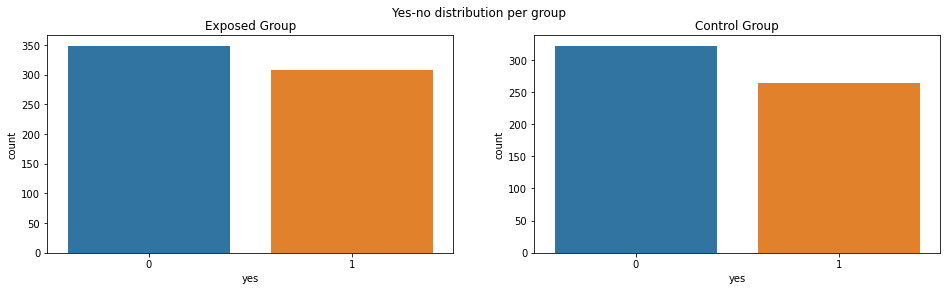

In [6]:
sample_size = 550

##data processing here
exposed, control = transform_data(clean_ad_df, sample_size)

##plot data summary
plotDataSummary(exposed,control)

In [7]:
seq_test=SequentialTest(exposed, control, sample_size)

pretyPrintTestResult(seq_test)

{'name': 'Sequential AB Testing',
 'engagementCountControl': 586,
 'engagementCountExposed': 657,
 'positiveCountControl': 250,
 'positiveCountExposed': 253,
 'TotalObservation': 'sample size too small'}